In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
import field_level.inference as inference
import field_level.coord as coord
import field_level.cosmo_util as cosmo_util
import field_level.power_util as power_util

import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
import jax
import jax.scipy as jsp
from jax import jit

import sys

numpyro.set_host_device_count(3)

### Load the mock data and measure its power spectrum

In [15]:
data_root = '/data/kakitsu/field_level/mock_data/'

boxsize = 2000.0
redshift = 0.5
true_log_Perr = 8.0
true_b1 = 2.0

mock_signal = np.load(data_root + f'cosmo_{boxsize}_z{redshift}_s1995_gauss_512_768_128.npy')
#mock_signal = np.load(data_root + f'cosmo_{boxsize}_z{redshift}_s1995_gauss_rsd_512_768_128_{true_b1}.npy')

mock_noise = np.load(data_root + f'{boxsize}_Gaussian_{true_log_Perr}_128_2006.npy')

mock_data = mock_signal + mock_noise

kbin, pk0, Nk = power_util.power_compute(jnp.array(mock_data), 
                                         jnp.array(mock_data), 
                                         boxsize, nbin=20, kmin=0.0, kmax=0.2)

kbin, pk2, Nk = power_util.power_compute(jnp.array(mock_data), 
                                         jnp.array(mock_data), 
                                         boxsize, nbin=20, kmin=0.0, kmax=0.2,
                                         ell=2)

kbin, pk4, Nk = power_util.power_compute(jnp.array(mock_data), 
                                         jnp.array(mock_data), 
                                         boxsize, nbin=20, kmin=0.0, kmax=0.2,
                                         ell=4)

pk0 = pk0.real
pk2 = pk2.real
pk4 = pk4.real

### Prepare the model

In [16]:
from field_level.forward_model import Forward_Model

model_name = 'gauss'
#model_name = 'gauss_rsd'

which_pk = 'cosmo'
ng = 128
ng_L = int(1.5*ng)
ng_E = 128
ng_params = [ng, ng_L, ng_E]

boxsize = 2000.0

kf = 2.*jnp.pi/boxsize
kny = jnp.pi/boxsize*ng

which_space = 'k_space' ### currently no effect

f_model = Forward_Model(model_name, which_pk, ng_params, boxsize, which_space)

model =  gauss


In [17]:
### get the linear matter power spectrum from JAX-CosmoPower

omega_b = 0.02242 ### Omega_b h^2
omega_c = 0.11933 ### Omega_cdm h^2
hubble = 0.73
ns = 0.9665
ln1010As = 3.047
OM0 = (omega_c + omega_b)/hubble/hubble

growth_f = cosmo_util.growth_f_fitting(redshift, OM0)
print('growth_f = ', growth_f)

cosmo_params = [omega_b, 
                omega_c,
                hubble,
                ns,
                ln1010As,
                0.0]   ### for the sigma8 computation

pk_lin = f_model.linear_power(cosmo_params)
true_sigma8 = f_model.sigma8(pk_lin)
print('sigma8 =', true_sigma8)
cosmo_params[-1] = redshift
pk_lin = f_model.linear_power(cosmo_params)


growth_f =  0.7175181128407132
sigma8 = 0.8350423924781688


In [18]:
kmin = 0.0
kmax = 0.1
kbin_data = kbin[kbin<=kmax]
Nk_data = Nk[kbin<=kmax]

pk0_data = pk0[kbin<=kmax]
pk2_data = pk2[kbin<=kmax]
pk4_data = pk4[kbin<=kmax]

### for real space
#pk_data = pk0_data

nbin = len(kbin_data)
pk_data = jnp.hstack([pk0_data, pk2_data, pk4_data])

### Covariance of pk with the discreteness

In [19]:
import importlib
importlib.reload(power_util)

true_Perr = jnp.exp(true_log_Perr)

f_model.kvecs(0.1)

### for rsd
#pk_3d = (true_b1 + growth_f*f_model.mu2_E )**2 * jnp.interp( jnp.sqrt(f_model.k2_E), pk_lin[0], pk_lin[1] ) + true_Perr  
#ellmax = 4

### for real space
pk_3d = jnp.interp( jnp.sqrt(f_model.k2_E), pk_lin[0], pk_lin[1] ) + true_Perr
ellmax = 0

cov = power_util.covariance_legendre_compute(pk_3d, boxsize, nbin=10, kmin=0.0, kmax=kmax, ellmax=ellmax)

In [20]:
### check the weighted pk 

pk_tmp = pk_lin
pk_tmp = pk_tmp.at[1].add(true_Perr)
pk_weight = power_util.power_weight_compute(pk_tmp, jnp.sqrt(f_model.k2_E), f_model.mu2_E, nbin=nbin, kmin=kmin, kmax=kmax, ellmax=ellmax)

plt.plot(kbin_data, kbin_data*pk_weight[:10])
plt.plot(kbin_data, kbin_data*pk_data[:10])

### Inference

In [21]:

def pk_model(pk_data):
    omega_c = numpyro.sample('oc', dist.Uniform(0.05, 0.355))
    #omega_c = 0.11933
    hubble = numpyro.sample('hubble', dist.Uniform(0.64, 0.82))
    #hubble = 0.73
    H0 = numpyro.deterministic('H0', hubble*100)
    OM = numpyro.deterministic('OM', (omega_b + omega_c)/hubble/hubble)
    cosmo_params_local = jnp.array([omega_b, 
                                    omega_c,
                                    hubble,
                                    ns,
                                    ln1010As,
                                    0.0])
    pk_lin = f_model.linear_power(cosmo_params_local)
    ### sampling simga8
    #tmp_sigma8 = f_model.sigma8(pk_lin, type_integ='trap')
    #sigma8 = numpyro.sample('sigma8', dist.Uniform(true_sigma8*0.5, true_sigma8*1.5))
    #A = numpyro.deterministic('A', sigma8/tmp_sigma8)
    
    ### or sampling A
    A = numpyro.sample('A', dist.Uniform(0.5, 1.5))
    sigma8 = numpyro.deterministic('sigma8', A * f_model.sigma8(pk_lin, type_integ='trap'))
    A2 = A*A
    
    cosmo_params_local = cosmo_params_local.at[-1].set(redshift)
    pk_lin = f_model.linear_power(cosmo_params_local)
    #model_pk = jnp.interp(kbin_data, pk_lin[0], pk_lin[1])
    #model_pk *= A2
    pk_lin = pk_lin.at[1].multiply(A2)

    log_Perr = numpyro.sample("log_Perr", dist.Normal(true_log_Perr, 0.5))
    #log_Perr = 8.0
    Perr = jnp.exp(log_Perr)
    
    
    #model_pk0 = model_pk + Perr
    #model_pk2 = jnp.zeros_like(model_pk0)
    #model_pk4 = jnp.zeros_like(model_pk0)
    
    #pk_model = jnp.hstack([model_pk0, 
    #                       model_pk2,
    #                       model_pk4])
    
    model_pk = jnp.array([pk_lin[0],
                          pk_lin[1] + Perr])
    
    pk_model = power_util.power_weight_compute(model_pk, 
                                               jnp.sqrt(f_model.k2_E), 
                                               f_model.mu2_E, 
                                               nbin=nbin, kmin=kmin, kmax=kmax, ellmax=ellmax)
    
    Y = numpyro.sample('Y', dist.MultivariateNormal(loc=pk_model, covariance_matrix=cov), obs=pk_data)


In [24]:
accept_rate = 0.8

kernel = numpyro.infer.NUTS(model=pk_model,
                            target_accept_prob=accept_rate,
                            adapt_step_size=True,
                            adapt_mass_matrix=True,
                            max_tree_depth=(8, 8),
                            init_strategy=numpyro.infer.init_to_sample)


mcmc = numpyro.infer.MCMC(kernel,
                          num_samples=200,
                          num_warmup=100,
                          num_chains=1,
                          thinning=1,
                          chain_method="parallel",
                          progress_bar=True)



In [25]:
posterior = {}

mcmc_seed = 2004
rng_key = jax.random.PRNGKey(mcmc_seed)
mcmc.run(rng_key, pk_data=pk_data[:nbin], extra_fields=('potential_energy',))
posterior['pow'] = mcmc.get_samples(group_by_chain=True)

sample:  72%|███████▏  | 217/300 [33:49<25:29, 18.43s/it, 255 steps of size 4.40e-03. acc. prob=0.95]  

In [ ]:
import pickle

with open('/home/kakitsu/field_level/field_level/analysis/samples/weighted_pk.pkl', 'wb') as f:
    pickle.dump(posterior['pow'], f)

/home/kakitsu/python/jax0423_env39/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>],
       [<Axes: title={'center': 'log_Perr'}>,
        <Axes: title={'center': 'log_Perr'}>]], dtype=object)

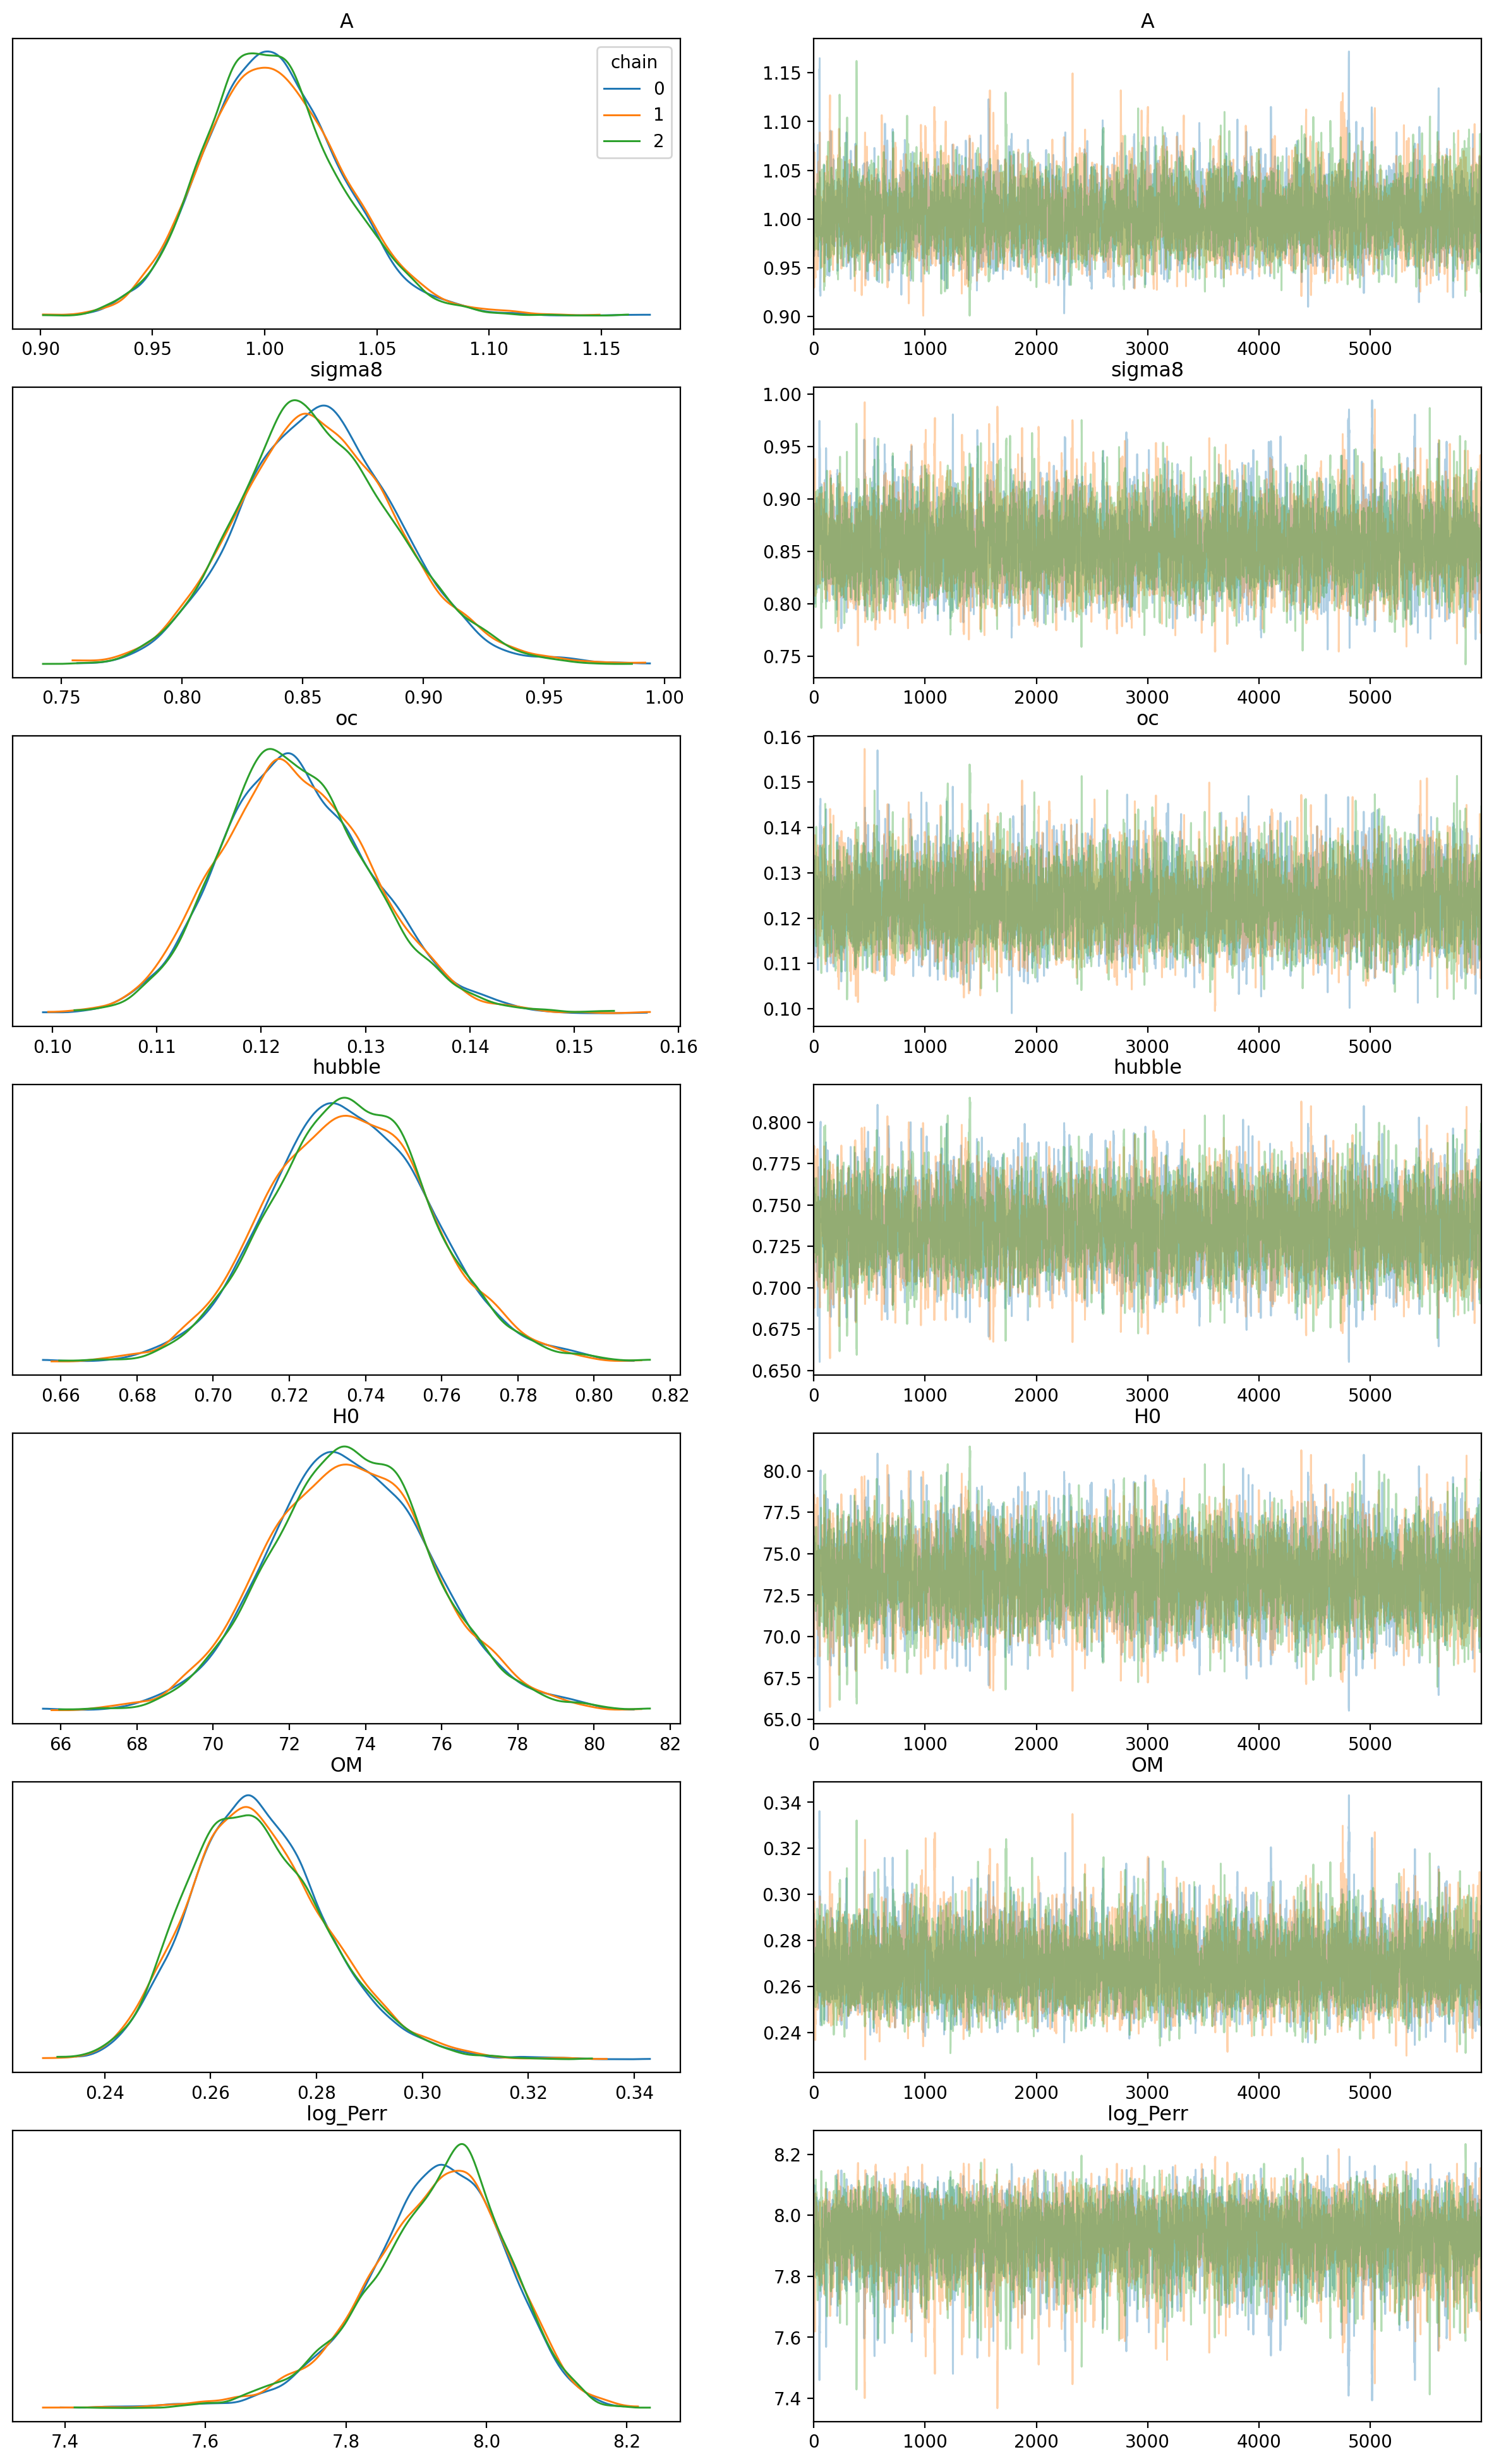

In [ ]:
%matplotlib inline

import arviz as az

params_pow = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
#params_pow = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM',]
#params_pow = ['A', 'sigma8', 'oc', 'OM',]
#params_pow = ['A', 'sigma8', 'hubble', 'H0', 'OM', 'log_Perr']
#params_pow = ['A', 'sigma8', 'oc', 'OM', 'log_Perr']


az.plot_trace(posterior['pow'], 
              var_names=params_pow,
              legend=True,
              compact=False,
              figsize=(15, 3.5*len(params_pow)),
              coords={'chain':[0,1,2,]})

In [ ]:
az.summary(posterior['pow'],
           var_names=params_pow,
           round_to=10,
           coords={"chain":[0,1,2]})

mean        sd     hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
A          1.004116  0.030735   0.947740   1.061750   0.000440  0.000312   
sigma8     0.856839  0.032828   0.796094   0.918620   0.000441  0.000313   
oc         0.123324  0.007237   0.109874   0.136823   0.000101  0.000072   
hubble     0.735961  0.021181   0.695978   0.775437   0.000305  0.000216   
H0        73.596064  2.118098  69.597750  77.543666   0.030473  0.021585   
OM         0.269296  0.013286   0.245680   0.294609   0.000177  0.000127   
log_Perr   7.925412  0.102925   7.729451   8.107968   0.001406  0.000994   

             ess_bulk     ess_tail     r_hat  
A         4956.134076  5746.894529  1.000646  
sigma8    5641.825526  5531.264997  1.000509  
oc        5227.262866  6591.699716  1.000834  
hubble    4848.651414  5475.681002  1.000703  
H0        4848.651414  5475.681002  1.000703  
OM        5991.640342  5531.650610  1.000452  
log_Perr  5661.868015  5213.676376  1.000344

### Load the samples of the field-level

In [ ]:
root_data = '/data/kakitsu/field_level'

def name_to_label(param_name):
    if param_name == 'A':
        return 'A'
    if param_name == 'sigma8':
        return '\sigma_8'
    if param_name == 'hubble':
        return 'h'
    if param_name == 'H0':
        return 'H_0'
    if param_name == 'oc':
        return r'\omega_{\rm cdm}'
    if param_name == 'OM':
        return r'\Omega_{\rm m}'
    if param_name == 'log_Perr':
        return r'\mathrm{log}(P_{\rm err})'
    if param_name == 'b1':
        return r'b_1'
    if param_name == 'b2':
        return r'b_2'
    if param_name == 'bG2':
        return r'b_{\mathcal{G}_2}'
    if param_name == 'bGamma3':
        return r'b_{\Gamma_3}'
    if param_name == 'cs2':
        return r'c_s^2'
    if param_name == 'c1':
        return r'c_1'
    if param_name == 'growth_f':
        return r'f'
    if param_name == 'Sigma2':
        return r'\Sigma^2'
    if param_name == 'Sigma2_mu2':
        return r'\Sigma_{\mu^2}^2'

In [ ]:
### common params

which_ics = 'varied_ics'
which_pk = 'cosmo'

boxsize = 2000.0
redshift = 0.5

seed = 1995

ng_data = 512
ng = 128
ng_L = int(1.5*ng)

ng_E = 128
ngs_data = [ng_data, int(1.5*ng_data), ng_E]

MAS = ''
bias_params = ''

err_type = 'Gaussian'
true_log_Perr = 8.0
seed_n = 2006
err_data_name = f'{err_type}_{true_log_Perr}_{ng_E}_{seed_n}'

accept_rate = 0.8

cosmo_params_keys = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
err_params_keys = ['log_Perr']
bias_params_keys = ['b1', 'b2', 'bG2', 'bGamma3', 'cs2', 'c1']
stat_params_keys = ['potential_energy']

chains = [0,1,2]

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'log_Perr':8.0}

In [ ]:
which_ics = 'varied_ics'
which_pk = 'cosmo'

boxsize = 2000.0
redshift = 0.5
kmax = 0.1

seed = 1995
data_model = 'gauss'
model_name = 'gauss'

ng_data = 512
ng = 128
ng_L = int(1.5*ng)

ng_E = 128
ngs_data = f'{ng_data}_{int(1.5*ng_data)}_{ng_E}'
ngs_name = f'{ng}_{int(1.5*ng)}_{ng_E}'

MAS = ''
bias_params = ''
#b1 = 2.0
#bias_params = f'_{b1}'


data_name = f'{which_pk}_{boxsize}_z{redshift}_s{seed}_{data_model}_{ngs_data}{MAS}{bias_params}'

bias_name = ''
#bias_name = '_b1'

dense_mass_names = ['A_oc_hubble_log_Perr', 'A']
#dense_mass_names = ['A_oc_hubble_b1_log_Perr',]
#dense_mass_names = ['A_oc_log_Perr', 'A']
#dense_mass_names = ['A_hubble_log_Perr', 'A']
#dense_mass_names = ['A_oc_log_Perr', 'A']


for amp in ['A',]:
    cosmo_name = f'_{amp}_oc_hubble'
    #cosmo_name = f'_{amp}_oc'
    #cosmo_name = f'_{amp}_hubble'
    for err_name in ['_log_Perr', '_fixed_log_Perr']:
        params = []
        params += stat_params_keys
        params += cosmo_params_keys
        #params += ['A', 'sigma8', 'oc', 'OM']
        #params += ['A', 'sigma8', 'hubble', 'H0', 'OM']
        ### for bias
        #params += [bias_params_keys[0]]
        if not 'fixed' in err_name:
            params += err_params_keys
        for dense_mass_name in dense_mass_names:
            if 'fixed_log_Perr' in err_name and len(dense_mass_name) > 1:
                dense_mass_name = dense_mass_name[:-9]
                err_name = ''
            if 'sigma8' in amp:
                dense_mass_name = 'sigma8' + dense_mass_name[1:]
            print('dense_mass_name =', dense_mass_name)
            name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'
            path_base = f'{root_data}/{which_ics}/{name_base}'
            print('params =',params)
            print('name_base =',name_base)
            posterior[f'{name_base}'] = {}
            for param in params:
                #print(param)
                for i_chain in chains:
                    if i_chain == 0 :
                        posterior[f'{name_base}'][param] = np.loadtxt(f'{path_base}_{param}_chain{i_chain}.dat')
                    else:
                        tmp = np.loadtxt(f'{path_base}_{param}_chain{i_chain}.dat')
                        posterior[f'{name_base}'][param] = np.vstack([posterior[f'{name_base}'][param], tmp])
            print(posterior[f'{name_base}'].keys())
            print('')

dense_mass_name = A_oc_hubble_log_Perr
params = ['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
name_base = cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_log_Perr_A_oc_hubble_log_Perr_0.1_0.8


dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr'])

dense_mass_name = A
params = ['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
name_base = cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_log_Perr_A_0.1_0.8
dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr'])

dense_mass_name = A_oc_hubble
params = ['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
name_base = cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_A_oc_hubble_0.1_0.8
dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM'])

dense_mass_name = A
params = ['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
name_base = cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_A_0.1_0.8
dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM'])



In [ ]:
#cosmo_name = '_sigma8_oc_hubble'
cosmo_name = '_A_oc_hubble'
#cosmo_name = '_A_oc'
#cosmo_name = '_A_hubble'

#err_name = ''
err_name = '_log_Perr'

params = []
params += cosmo_params_keys
#params +=  ['A', 'sigma8', 'hubble', 'H0', 'OM']
#params +=  ['A', 'sigma8', 'oc', 'OM']

dense_mass_name = 'A_oc_hubble_log_Perr'
#dense_mass_name = 'A_oc_log_Perr'
#dense_mass_name = 'A_hubble_log_Perr'

if 'sigma8' in cosmo_name:
    dense_mass_name = 'sigma8' + dense_mass_name[1:]
if err_name == '':
    dense_mass_name = dense_mass_name[:-9]
else:
    params += err_params_keys

name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'

az.plot_trace(posterior[f'{name_base}'], 
              var_names=params,
              legend=True,
              compact=False,
              figsize=(15, 3.5*len(params)),
              coords={'chain':chains})

/home/kakitsu/python/jax0423_env39/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>],
       [<Axes: title={'center': 'log_Perr'}>,
        <Axes: title={'center': 'log_Perr'}>]], dtype=object)

In [ ]:
az.summary(posterior[f'{name_base}'],
           var_names=params,
           round_to=10,
           coords={"chain":[0,1,2,]})
           #coords={"chain":[1,2,]})

mean        sd     hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
A          1.019032  0.030076   0.962783   1.075186   0.000561  0.000401   
sigma8     0.853398  0.031675   0.795611   0.911800   0.001907  0.001352   
oc         0.120369  0.006908   0.107604   0.133413   0.000312  0.000221   
hubble     0.724548  0.020101   0.687105   0.762423   0.000071  0.000050   
H0        72.454835  2.010079  68.710526  76.242271   0.007128  0.005049   
OM         0.272183  0.012747   0.249153   0.296450   0.000588  0.000417   
log_Perr   7.932397  0.097453   7.754555   8.109503   0.005956  0.004216   

              ess_bulk      ess_tail     r_hat  
A          3056.449978   5032.842454  1.000990  
sigma8      279.657401    606.962139  1.009015  
oc          490.347444   1932.177221  1.004993  
hubble    79593.067635  67029.923094  1.000148  
H0        79593.128334  67029.923094  1.000148  
OM          475.933932   1389.496490  1.005130  
log_Perr    273.228898    571.360161  1.009311

In [ ]:
from getdist import plots, MCSamples
import getdist

dense_mass_name = 'A_oc_hubble_log_Perr'
#dense_mass_name = 'A_hubble_log_Perr'

#samples = {}

for cosmo_name in ['_A_oc_hubble', ]:
    #for err_name in ['',]:
    for err_name in ['_log_Perr',]:
        params = []
        params += cosmo_params_keys
        #params += ['A', 'sigma8', 'hubble', 'H0', 'OM']
        #params += ['A', 'sigma8', 'oc', 'OM']
        if 'sigma8' in cosmo_name:
            dense_mass_name = 'sigma8' + dense_mass_name[1:]
        if err_name == '':
            dense_mass_name = dense_mass_name[:-9]
        else:
            params += err_params_keys
        labels = []
        for param in params:
            labels += [name_to_label(param)]
        name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'
        tmp = np.array(list(posterior[f'{name_base}'].values()))
        tmp = tmp.reshape(tmp.shape[0],
                          tmp.shape[1]*tmp.shape[2])
        print(tmp[1:,].shape)
        print(name_base)
        print(params)
        print(labels)
        samples[f'{name_base}'] = MCSamples(samples=tmp[1:,].T,
                                            names = params, 
                                            labels=labels,
                                            label = f'field level')


tmp_dict = {}
for key in params:
    tmp_dict[key] = posterior['pow'][key]
#posterior['pow'] = tmp_dict

samps_arr = np.array(list(tmp_dict.values()))
samps_arr = samps_arr.reshape(samps_arr.shape[0],
                              samps_arr.shape[1]*samps_arr.shape[2])

samples[f'pow_{name_base}'] = MCSamples(samples=samps_arr.T,
                                        names=params,
                                        labels=labels,
                                        label='power spectrum')


(7, 300000)
cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_log_Perr_A_oc_hubble_log_Perr_0.1_0.8
['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
['A', '\\sigma_8', '\\omega_{\\rm cdm}', 'h', 'H_0', '\\Omega_{\\rm m}', '\\mathrm{log}(P_{\\rm err})']
Removed no burn in
Removed no burn in


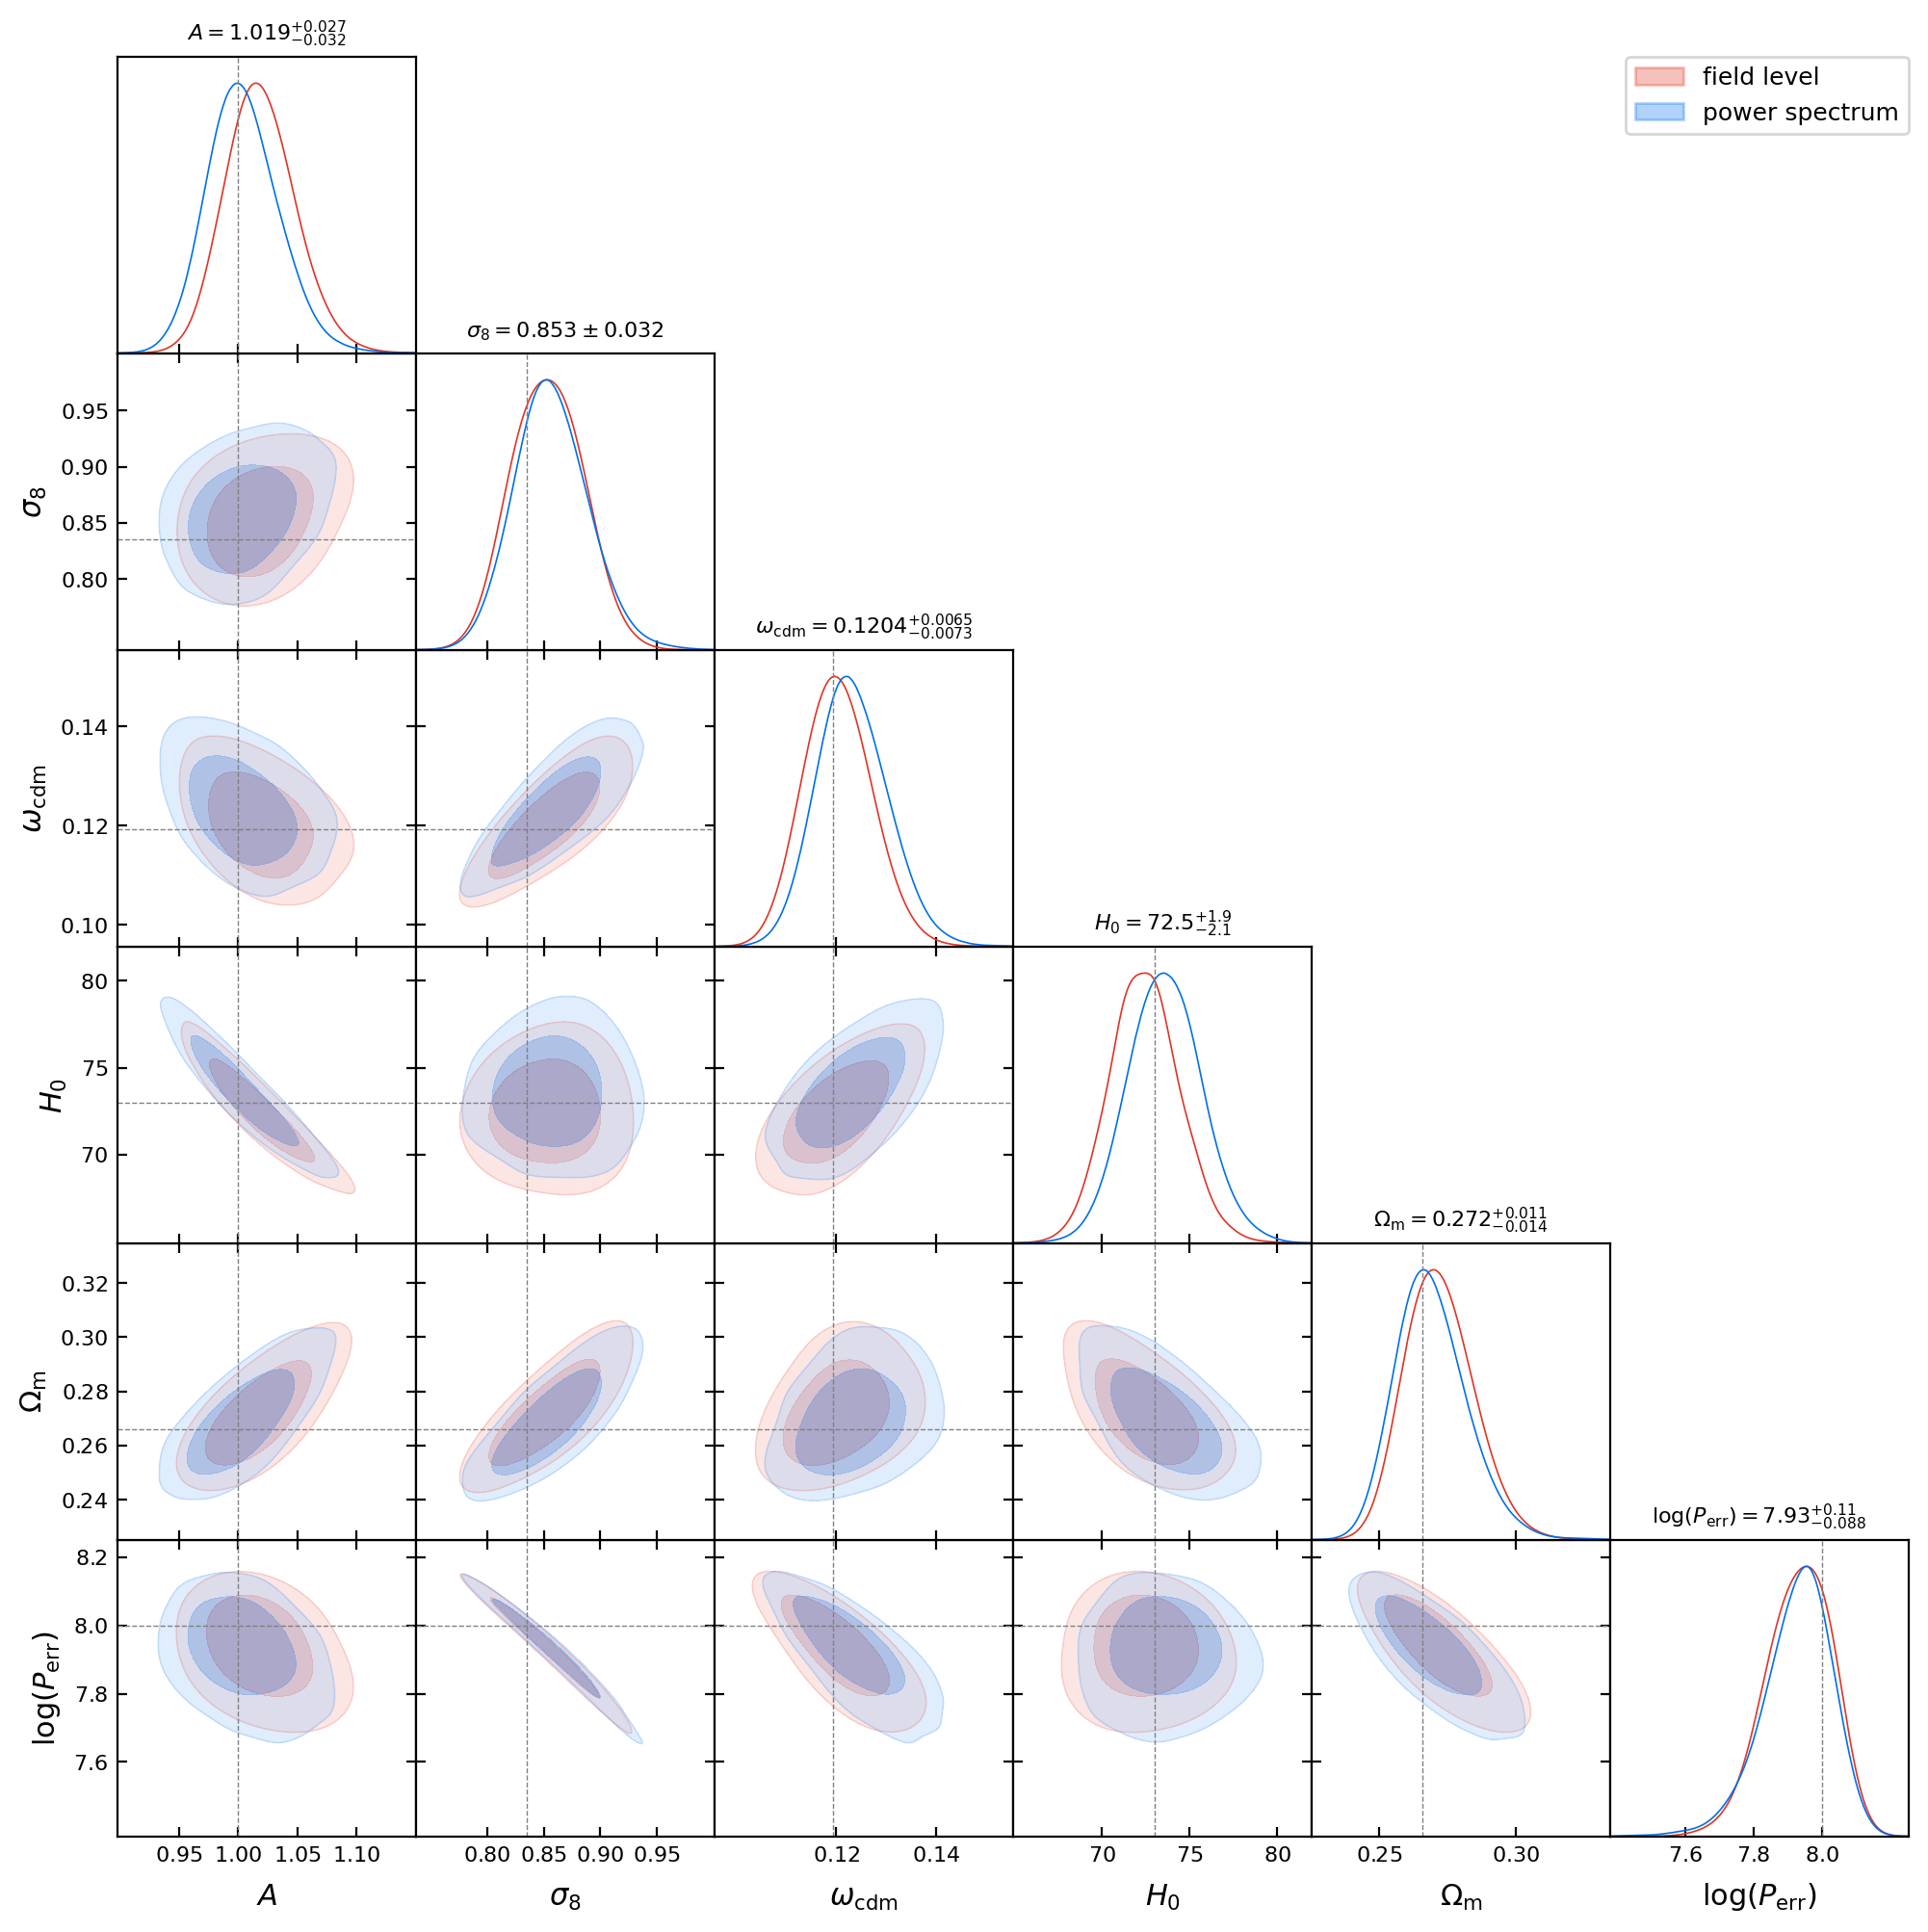

In [ ]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'{name_base}'],
                 samples[f'pow_{name_base}'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

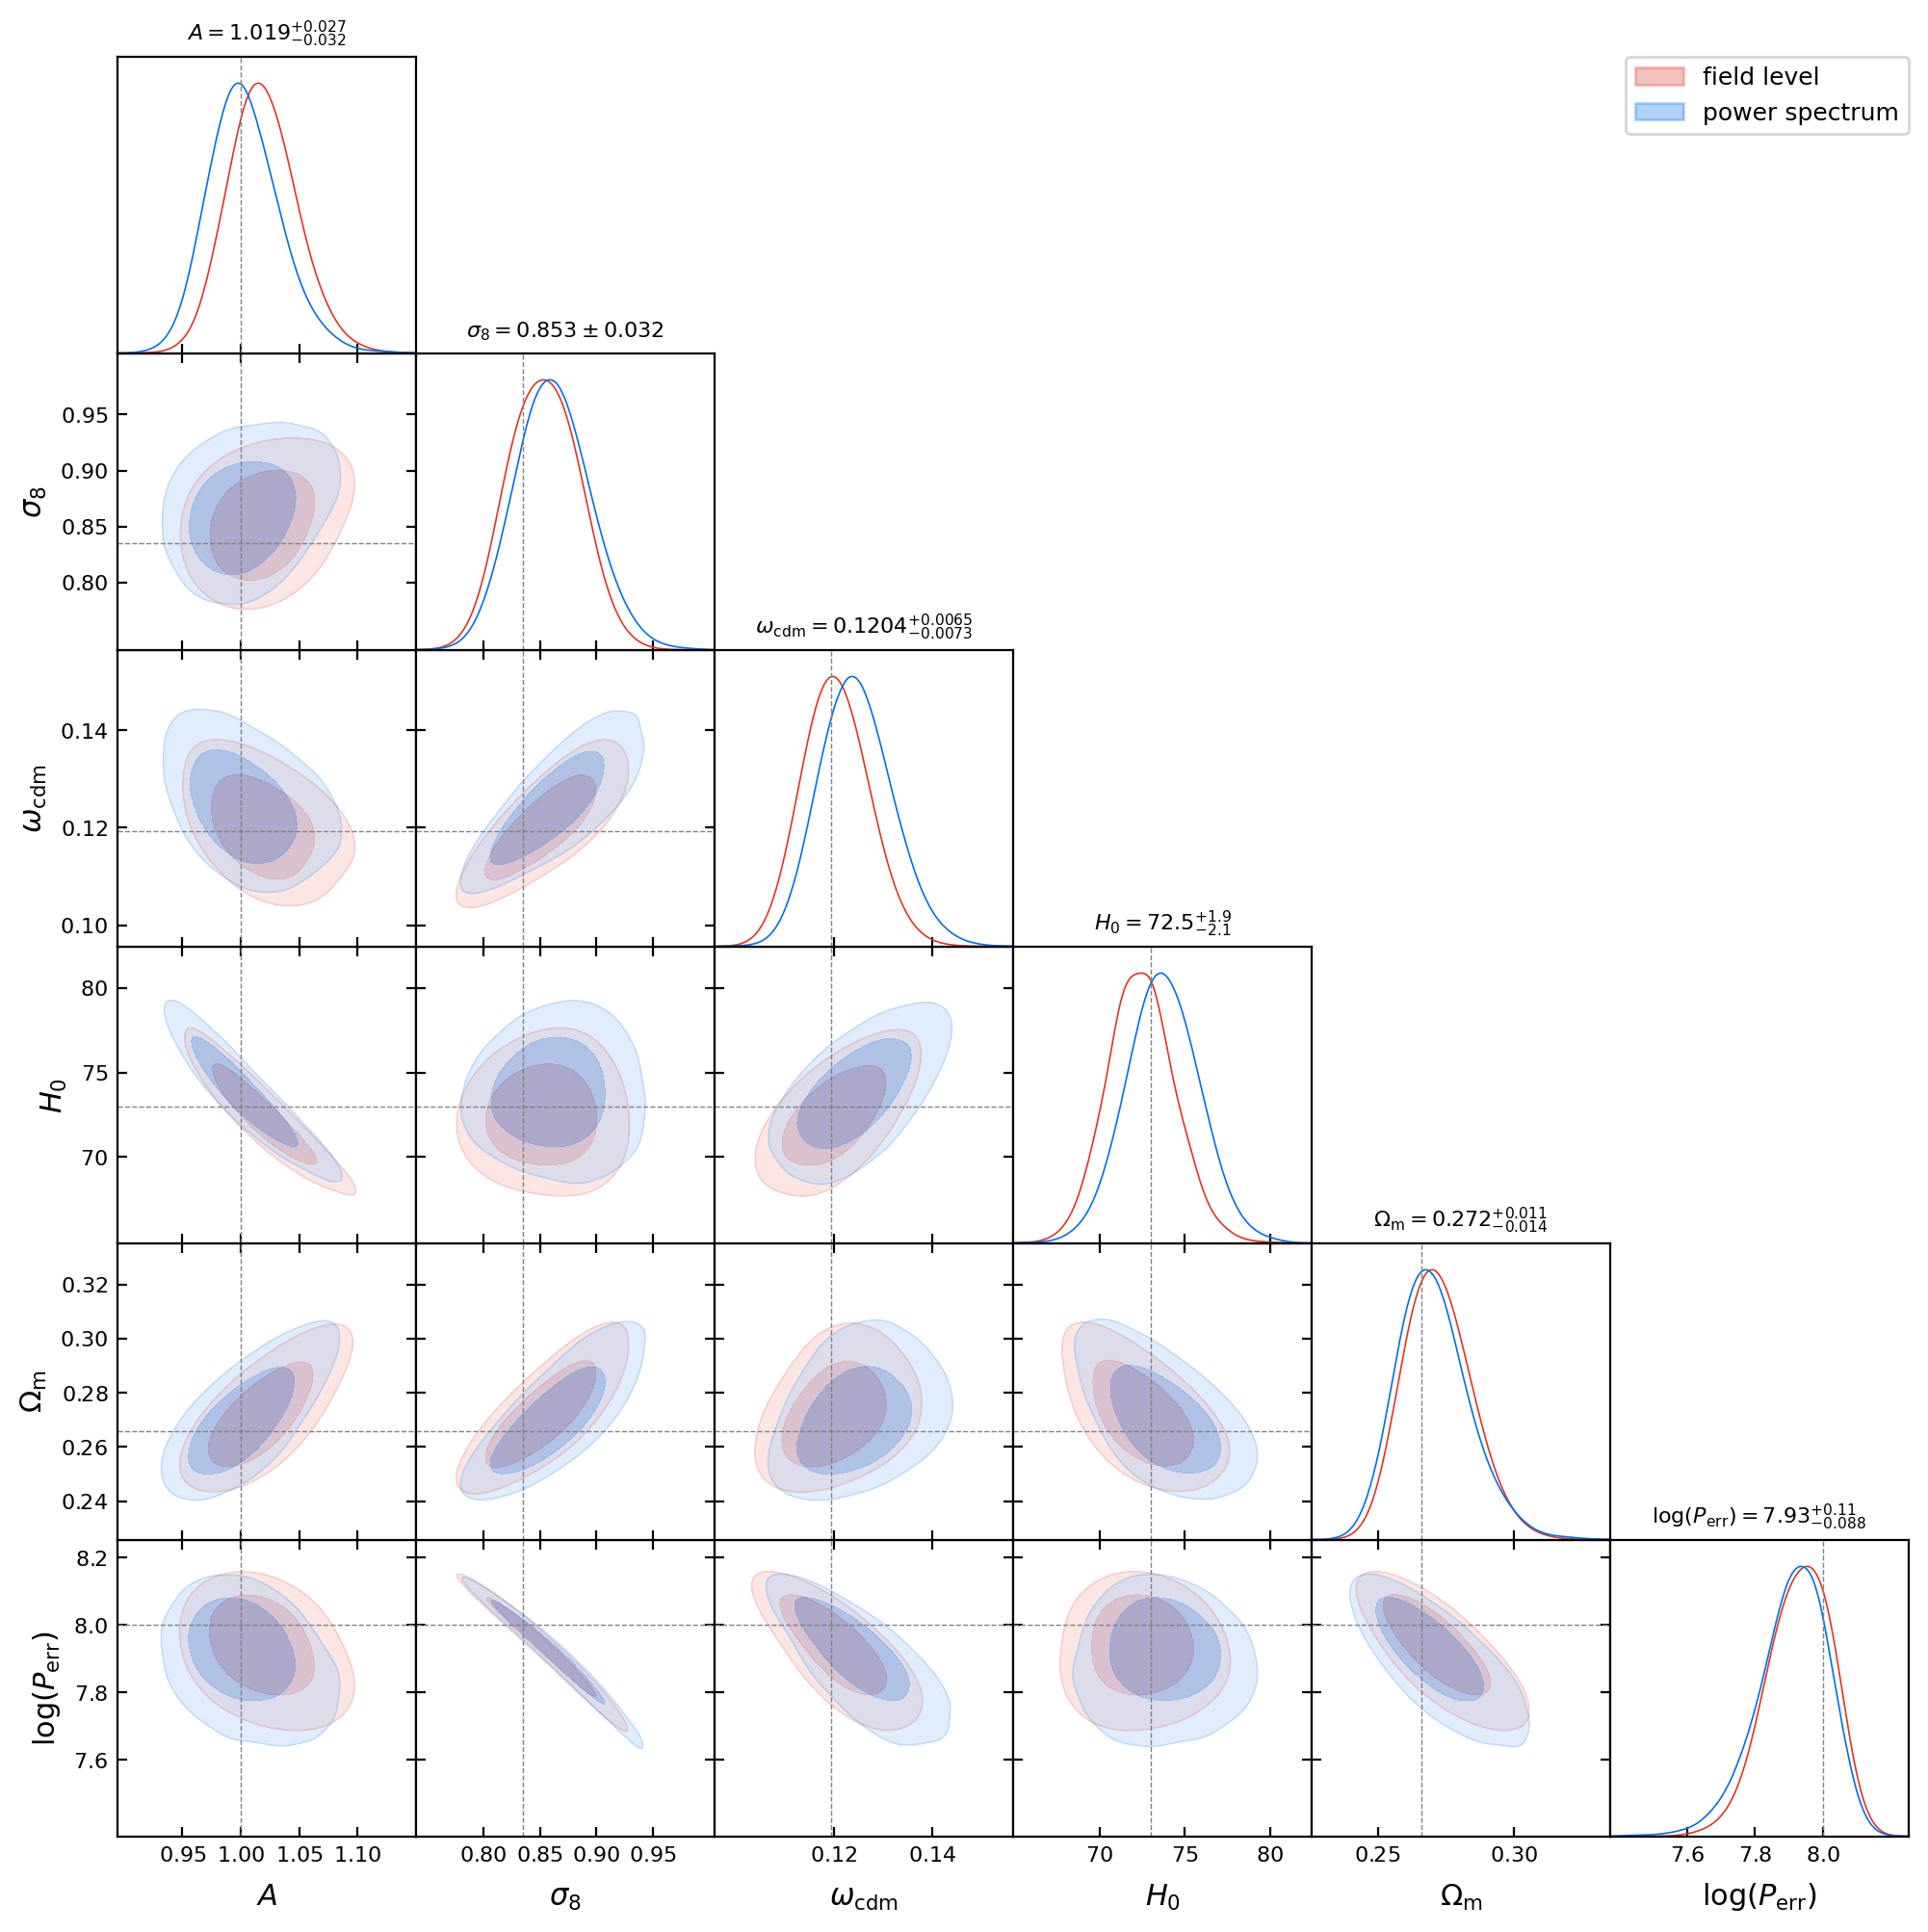

In [ ]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'{name_base}'],
                 samples[f'pow_{name_base}'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

### Compare to Stephen's results

In [ ]:
### load the data
import os
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

root_pk = '/home/kakitsu/field_level/full/from_stephen'

#which_model = 'updated_cosmopower/pk_k0.1_A_Perr_H0_linear_2Gpc_real_cosmopower'
#which_model = 'cosmopower/pk_k0.1_A_Perr_omch2_linear_2Gpc_real_cosmopower'
which_model = 'updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower'

samples_tmp = loadMCSamples(os.path.abspath(f'{root_pk}/{which_model}'),
                            settings={'ignore_rows':0.5}, no_cache=True)

#params_tmp = ['A', 'H0', 'logPerr']
params_tmp = ['A', 'omch2', 'H0', 'logPerr']

gdplot = gdplt.get_subplot_plotter()

gdplot.triangle_plot(samples_tmp,
                     params_tmp,
                     filled=True,
                     title_limit=1,contour_lws=2,
                     markers = {'A': 1.0, 'b1':1.0, 'omch2':omega_c, 'H0':73.0, 'logPerr':8.0})

/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.1.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.2.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.3.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.4.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.5.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.6.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.7.txt
/home/kakitsu/field_level/full/from_stephen/updated_cosmopower/pk_k0.1_A_Perr_H0_omch2_linear_2Gpc_real_cosmopower.8.txt
Removed 0.5 as burn in


In [ ]:
tmp_dict = np.array([samples_tmp['A'],
                     samples_tmp['omch2'],
                     samples_tmp['H0'],
                     samples_tmp['logPerr'],
                    ])

#params_contour = ['A', 'H0', 'log_Perr']
params_contour = ['A', 'oc', 'H0', 'log_Perr']

for param in params_contour:
    labels += [name_to_label(param)]

samples[f'stephen_pow_{name_base}'] = MCSamples(samples=tmp_dict.T,
                                                names=params_contour,
                                                labels=labels,
                                                label='power spectrum from Stephen')


Removed no burn in


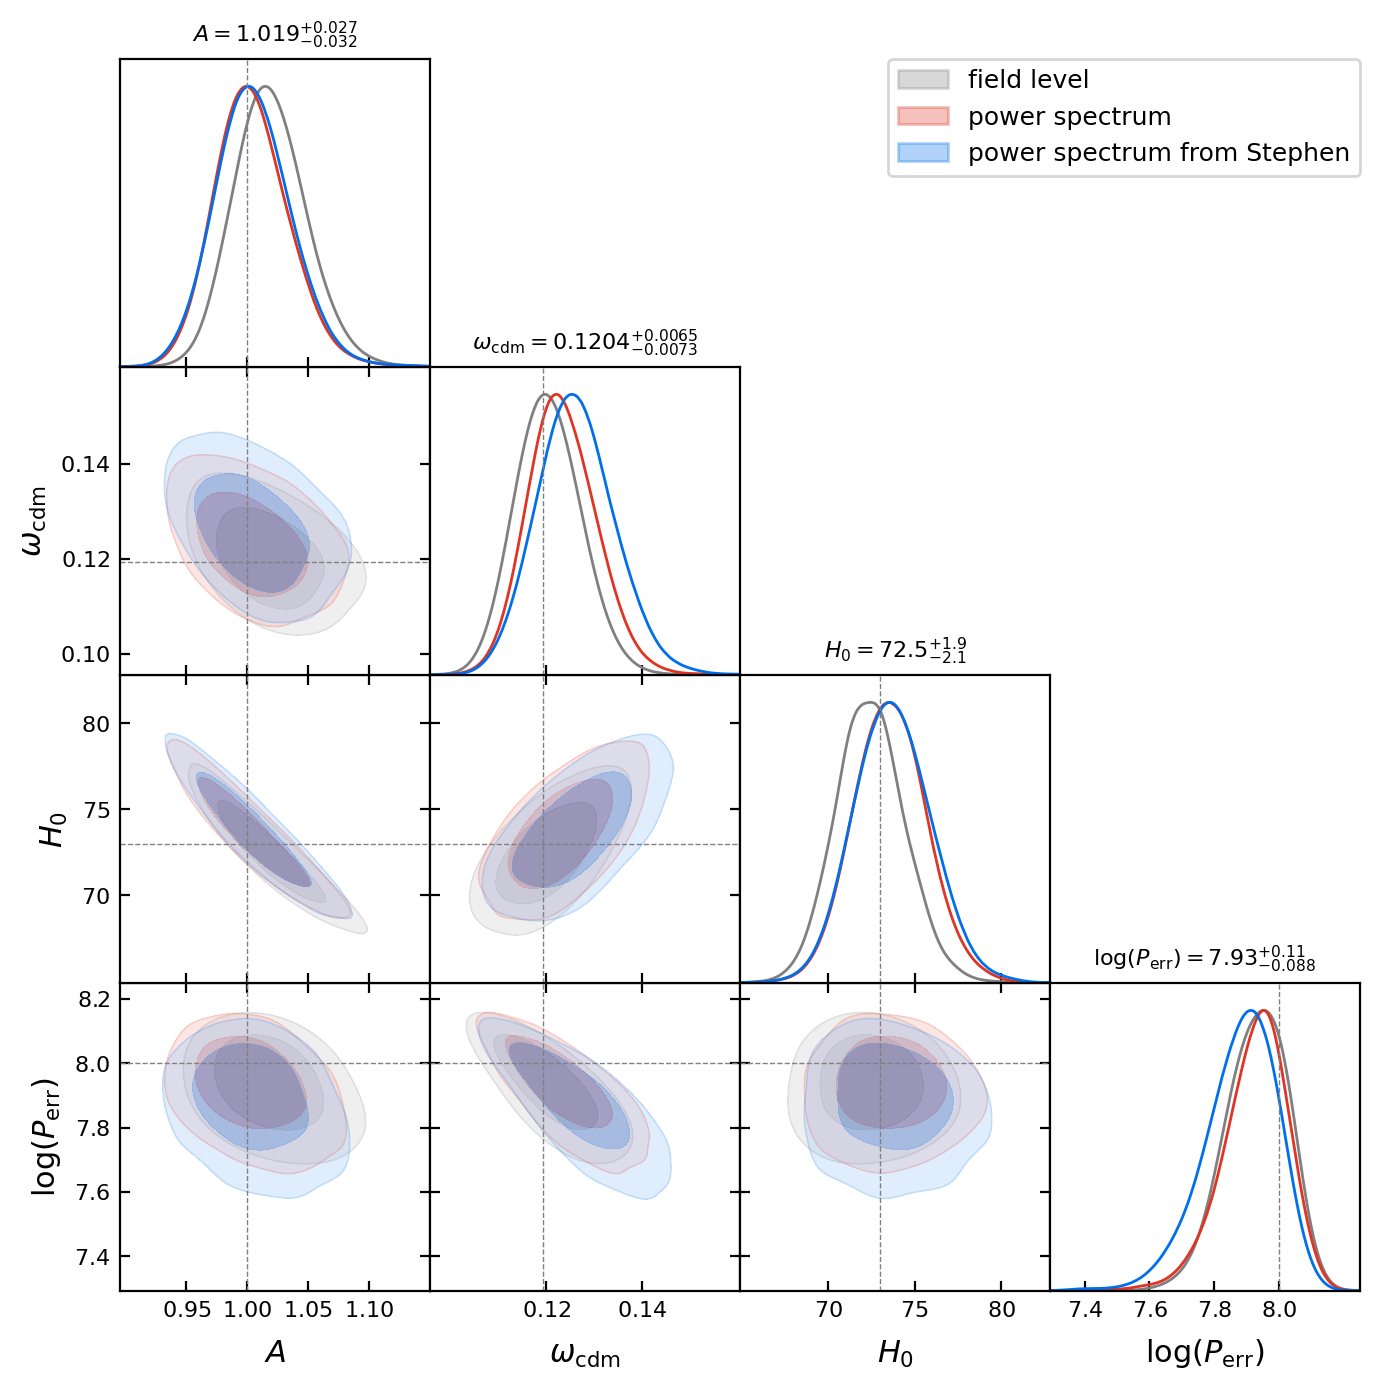

In [ ]:
gdplot.triangle_plot([samples[f'{name_base}'],
                      samples[f'pow_{name_base}'],
                      samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')


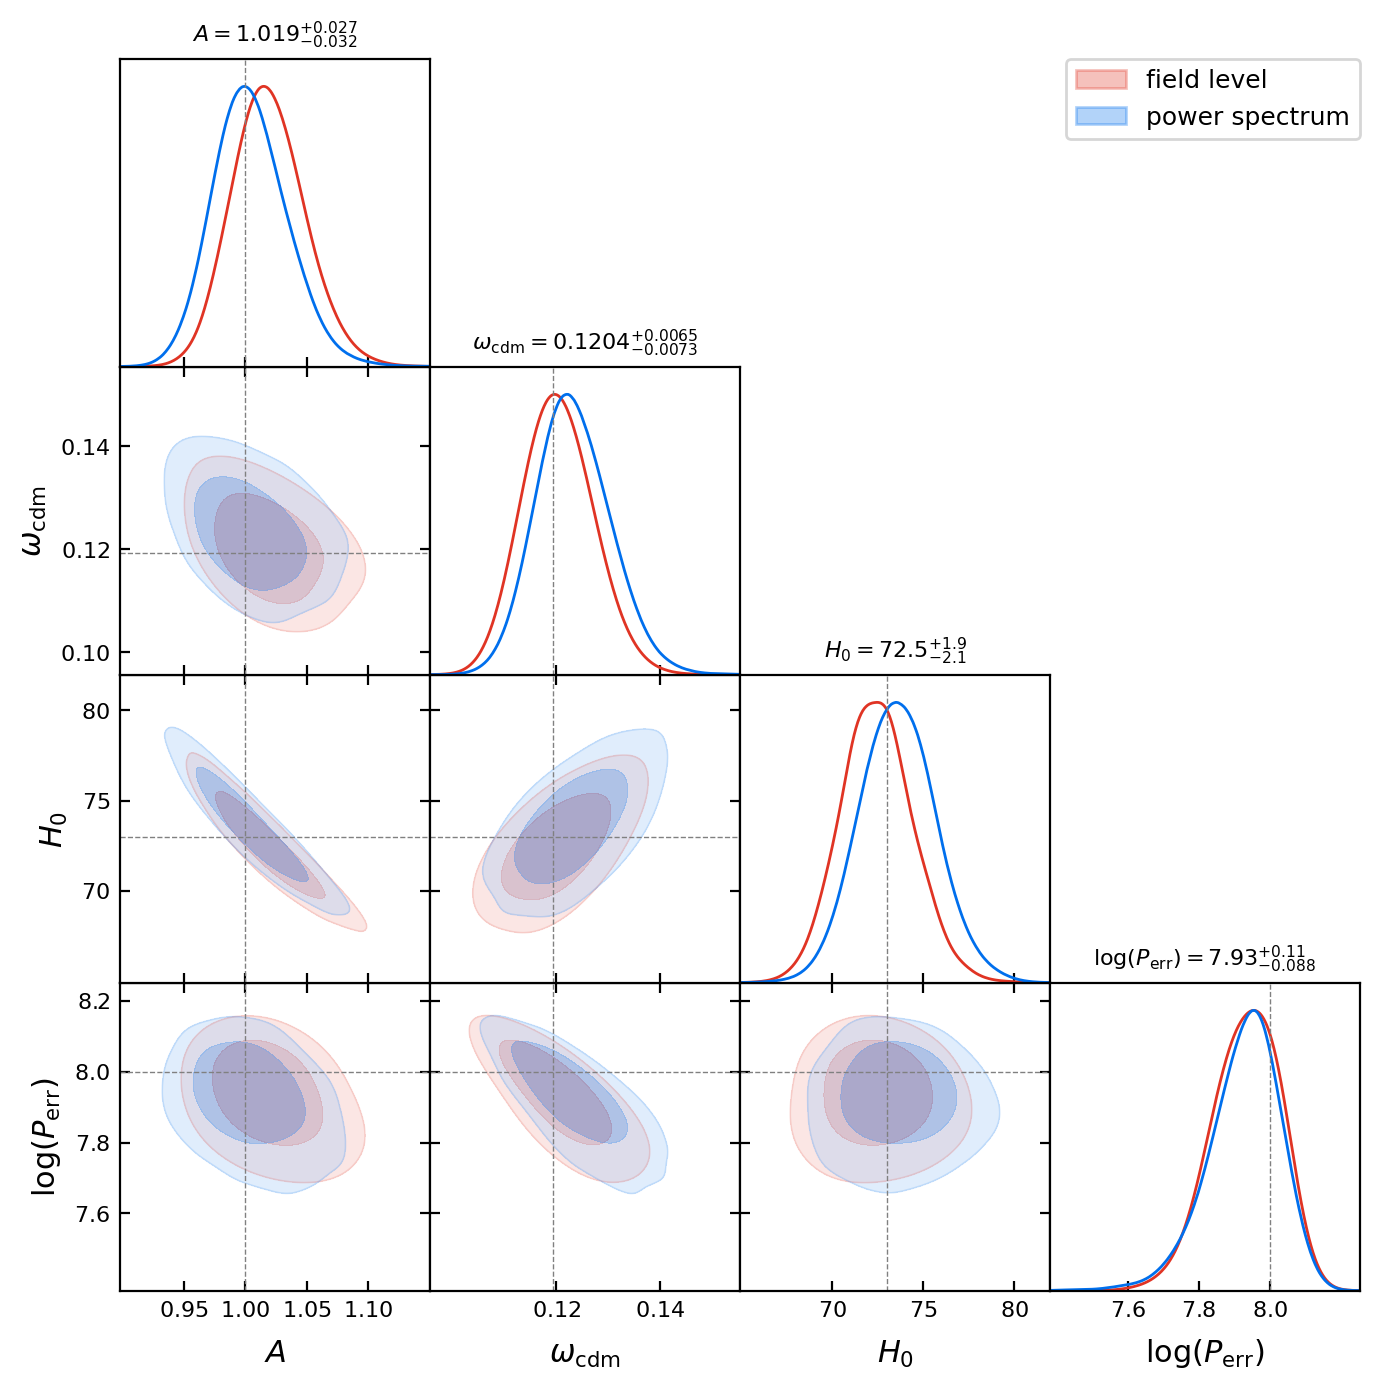

In [ ]:
gdplot.triangle_plot([samples[f'{name_base}'],
                      samples[f'pow_{name_base}'],
                      #samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')


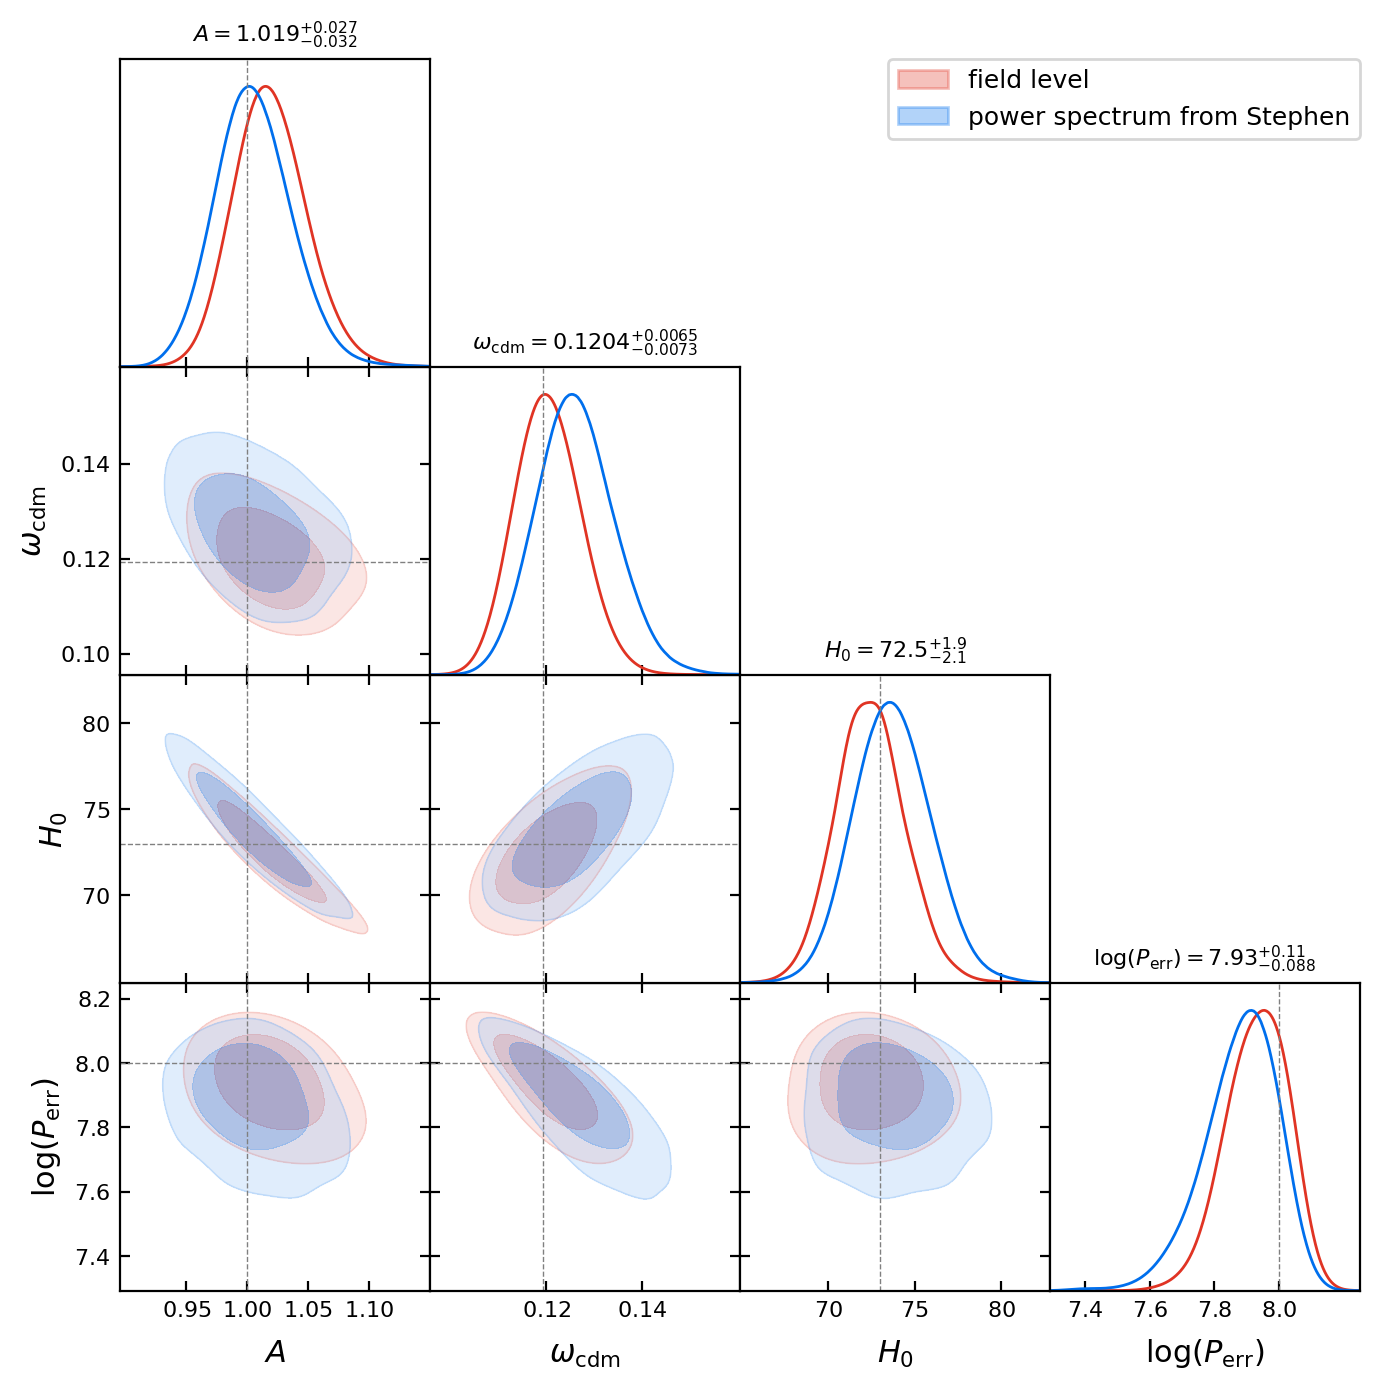

In [ ]:
gdplot.triangle_plot([samples[f'{name_base}'],
                      #samples[f'pow_{name_base}'],
                      samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')


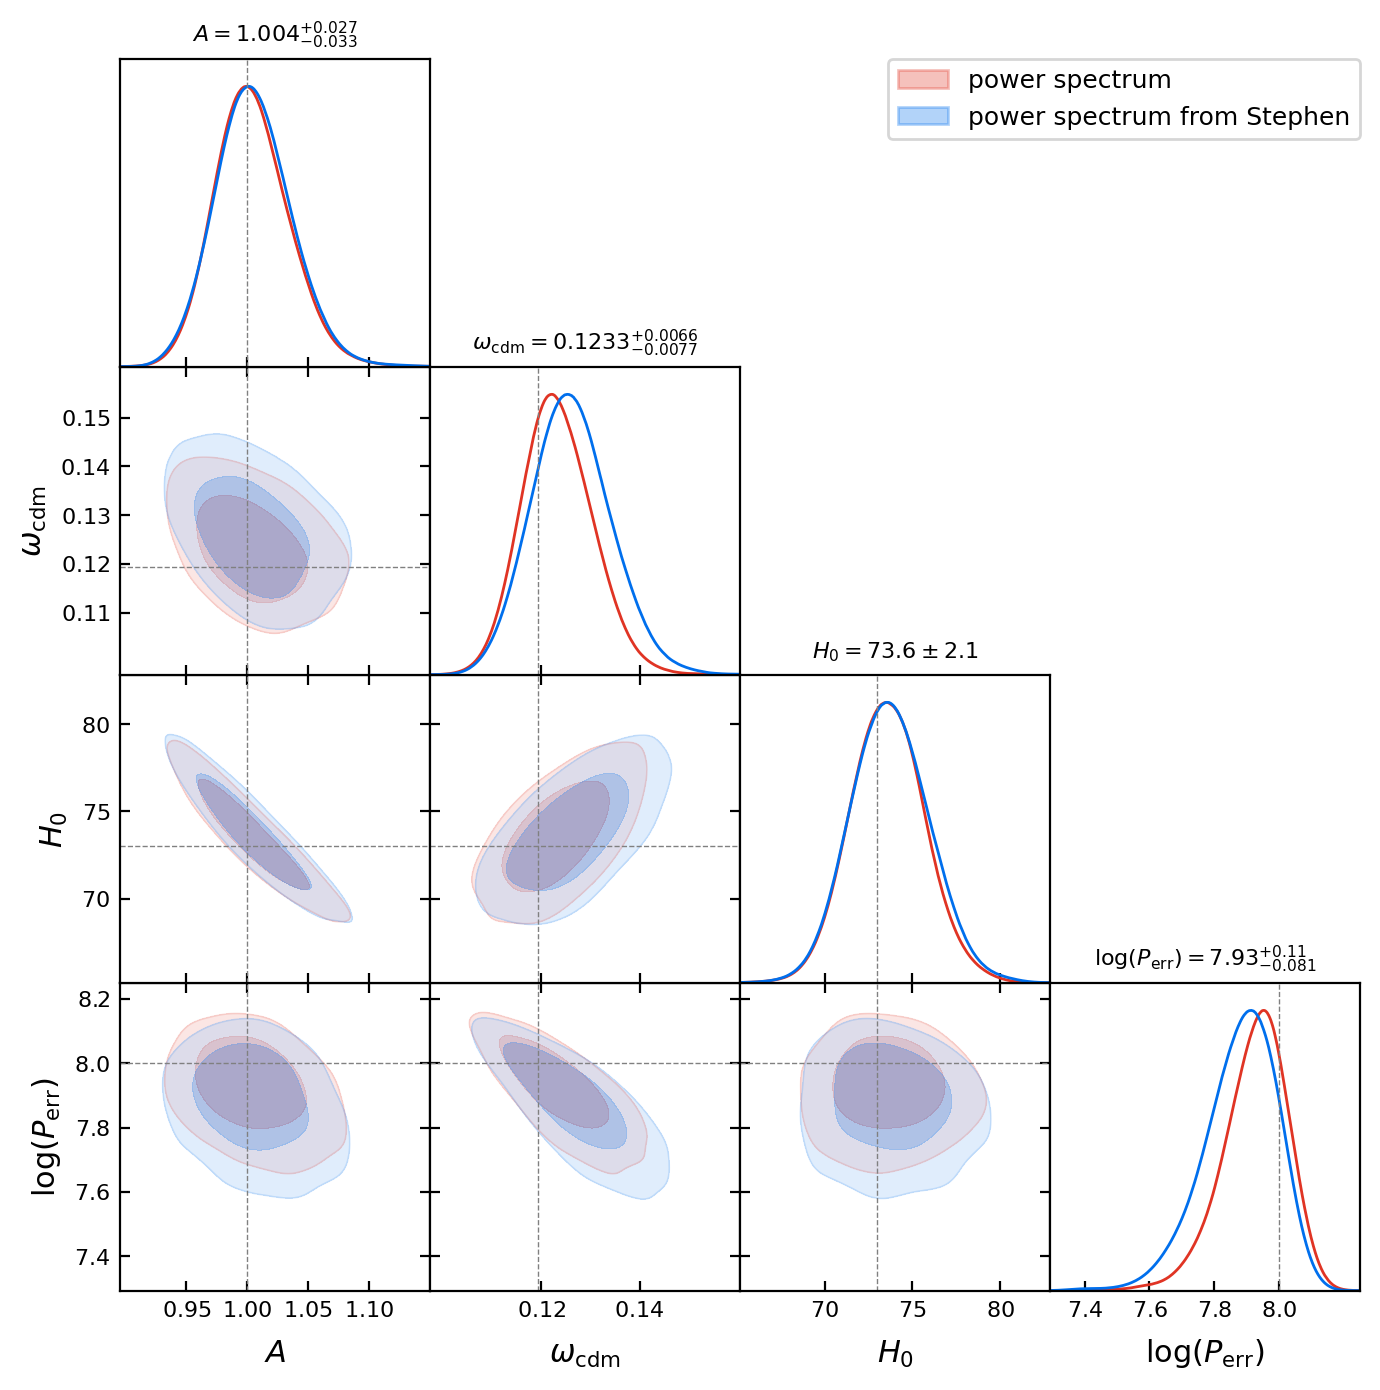

In [ ]:
gdplot.triangle_plot([#samples[f'{name_base}'],
                      samples[f'pow_{name_base}'],
                      samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')
